# Workflow & Hyperparameter Optimization

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp


🏠 Import the house price data set. We will keep only numerical features for the sake of simplicity

🎯 Your goal will be to fit the best KNN Regressor. In particular, how many "neighbors" (<font color=blue>K</font> in <font color=blue>K</font>NN) should you consider to get the best predictions for your house prices ?

In [2]:
# Load raw data
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv', index_col="Id")

# Only keep numerical columns and raws without NaN
data = data.select_dtypes(include=np.number).dropna()

data.head(1)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500


In [3]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

## 1. Train/Test split

❓ **Question (Holdout)**❓

👇 Split the dataset to create your `X_train` `X_test` and `y_train` `y_test`. Use:
- `test_size=0.3`
- `random_state=0` to compare your results with your buddy

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [5]:
print(X_train.shape)
X_train.head(1)

(784, 36)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
123,20,75.0,9464,6,7,1958,1958,135.0,570,0,...,288,0,0,0,0,130,0,0,6,2008


In [6]:
print(X_test.shape)
X_test.head(1)

(337, 36)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1008,160,21.0,2217,4,4,1970,1970,0.0,273,273,...,286,238,0,0,0,0,0,0,8,2009


## 2. Scaling

⚖️ Scaling is always crucially important for the KNN algorithm..

❓ **Question (Scaling)** ❓ 

* Scale your train set and test set.
* Here, let's simply apply the `StandardScaler` and not waste time choosing one scaler per feature. Indeed, the goals of this exercise are to:
    * review KNN
    * understand GridSearchCV
    * understand RandomizedSearchCV

In [7]:
standard_scaler = StandardScaler().set_output(transform="pandas")
standard_scaler.fit(X_train)

StandardScaler()

In [8]:
X_train_scaled = standard_scaler.transform(X_train)
X_train_scaled.head(1)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
123,-0.878719,0.186885,-0.066635,-0.159838,1.357895,-0.445886,-1.314462,0.108204,0.32695,-0.278554,...,-1.15113,-0.738939,-0.749484,-0.372566,-0.109954,2.195993,-0.061673,-0.146085,-0.110711,0.168285


In [9]:
X_test_scaled = standard_scaler.transform(X_test)
X_test_scaled.head(1)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1008,2.549942,-2.118464,-1.560069,-1.583853,-1.468449,-0.065155,-0.744894,-0.584157,-0.350113,1.653695,...,-1.161633,1.186195,-0.749484,-0.372566,-0.109954,-0.277928,-0.061673,-0.146085,0.631147,0.913683


## 3. Baseline KNN model

❓ **Question (A baseline for our KNN)** ❓

Cross-validate (*cv = 5*) a simple KNN regressor taking into account only _the closest neighbor_, and compute the average score over the 5 folds.

In [10]:
knn_reg_n1 = KNeighborsRegressor(n_neighbors=1)

In [11]:
cv_result = pd.DataFrame(
    cross_validate(estimator=knn_reg_n1, X=X_train_scaled, y=y_train, cv=5)
)
cv_result

,fit_time,score_time,test_score
0,0.010120,0.130754,0.542701
1,0.009357,0.027288,0.684186
2,0.008355,0.040992,0.250163
3,0.009721,0.027659,0.778582
4,0.009336,0.064183,0.545139


In [12]:
cv_result.mean()

fit_time      0.009378
score_time    0.058175
test_score    0.560154
dtype: float64

## 4. GridSearch

### 4.1. A first GridSearch

❓ **Question (GridSearch v1)**❓

Let's use SKLearn `GridSearchCV` to find the best KNN hyperparameter `n_neighbors`.
- Start a coarse-grain approach, with `n_neighbors` = [1,5,10,20,50]
- 5-fold cross-validate each parameter
- Make sure to maximize your performance time using `n_jobs`

In [13]:
# Instantiate model
knn_reg = KNeighborsRegressor()

# Hyperparameter Grid
grid = {"n_neighbors": [1, 5, 10, 20, 50]}

# Instantiate Grid Search
search = GridSearchCV(
    knn_reg, grid, scoring="r2", cv=5, n_jobs=-1, verbose=1  # parallelize computation
)

# Fit data to Grid Search
search.fit(X_train_scaled, y_train)
search

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50]}, scoring='r2',
             verbose=1)

❓ **Question (best parameters)** ❓

According to the GridSearch, what is the optimal K value?

In [14]:
search.best_estimator_

KNeighborsRegressor(n_neighbors=10)

❓ **Question (scoring)** ❓ What is the best score the optimal K value produced?

In [15]:
search.best_score_

0.7596697382171873

### 4.2. A second GridSearch

❓ **Question (GridSearch V2)** ❓


Now, we have an idea about where the best $K$ lies, but some of the values we didn't try could result in a  better performance.

* Re-run a GridSearch trying some values for $K$ around to your previous best value
* What are the `best_score` and `best_k` for this refined GridSearch?

In [16]:
# Instantiate model
knn_reg = KNeighborsRegressor()

# Hyperparameter Grid
grid = {"n_neighbors": np.arange(6, 19)}
print(grid)

# Instantiate Grid Search
search = GridSearchCV(
    knn_reg, grid, scoring="r2", cv=5, n_jobs=-1, verbose=1  # parallelize computation
)

# Fit data to Grid Search
search.fit(X_train_scaled, y_train)
search


{'n_neighbors': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])}
Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])},
             scoring='r2', verbose=1)

In [17]:
best_k = search.best_params_["n_neighbors"]

In [18]:
best_score = search.best_score_
best_score

0.7666311417513013

***🧪 Test your code***

In [19]:
from nbresult import ChallengeResult
result = ChallengeResult('knn',
                         best_k=best_k,
                         best_score=best_score)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/branchedelac/code/branchedelac/05-ML/05-Model-Tuning/data-workflow/tests
plugins: anyio-3.6.2, asyncio-0.19.0, typeguard-2.13.3
asyncio: mode=strict
collecting ... collected 2 items

test_knn.py::TestKnn::test_best_k PASSED                                 [ 50%]
test_knn.py::TestKnn::test_best_score PASSED                             [100%]

============================== 2 passed in 0.29s ===============================


💯 You can commit your code:

git add tests/knn.pickle

git commit -m 'Completed knn step'

git push origin master



### 4.3. Visual check (manual GridSearch)

☝️ This problem is actually simple enough to perform a GridSearch manually.

❓ **Question(Manual GridSearch)** ❓

- Loop manually over all values of $K$ from $1$ to $50$ and store the average of the cross-validated scores of each model in a list.
- Plot the scores as a function of $K$ to visually find the best $K$ using the `Elbow Method`

In [20]:
K_values = np.arange(1, 51)
K_and_score = {}

for K in K_values:
    knn_regressor_k = KNeighborsRegressor(n_neighbors=K)
    cv_score = cross_val_score(estimator=knn_regressor_k, X=X_train_scaled, y=y_train)
    K_and_score[cv_score.mean()] = K

print(K_and_score)

{0.5601542887874071: 1, 0.6748486262356018: 2, 0.7094117100400642: 3, 0.7361753607501019: 4, 0.7361762227737517: 5, 0.7510571142768178: 6, 0.7572068392877542: 7, 0.7561590320367425: 8, 0.754819823171375: 9, 0.7596697382171873: 10, 0.7564252007681446: 11, 0.7586299417691393: 12, 0.7628734645391733: 13, 0.7627066200261674: 14, 0.7657859104933367: 15, 0.7666311417513013: 16, 0.7634248761848345: 17, 0.7615312071889646: 18, 0.7620306590467042: 19, 0.7592919112558041: 20, 0.7579247168049423: 21, 0.7573995785226801: 22, 0.7576674663372694: 23, 0.7563331142574384: 24, 0.7554045554144178: 25, 0.7565378923259158: 26, 0.7540937431363772: 27, 0.7512614102706009: 28, 0.7508875418092524: 29, 0.749629436113443: 30, 0.7477489234086949: 31, 0.746923058113782: 32, 0.7456135260457453: 33, 0.7443057353821874: 34, 0.7427073921106258: 35, 0.7407531599046214: 36, 0.7388450521359882: 37, 0.7369326576613456: 38, 0.7358102131266511: 39, 0.7363587208891555: 40, 0.7344197149000499: 41, 0.7338499405971113: 42, 0.7

In [21]:
pd.Series(K_and_score).sort_index(ascending=False).head(5)

0.766631    16
0.765786    15
0.763425    17
0.762873    13
0.762707    14
dtype: int64

In [22]:
max_score = max(K_and_score.keys())
max_k = K_and_score[max_score]

<AxesSubplot:>

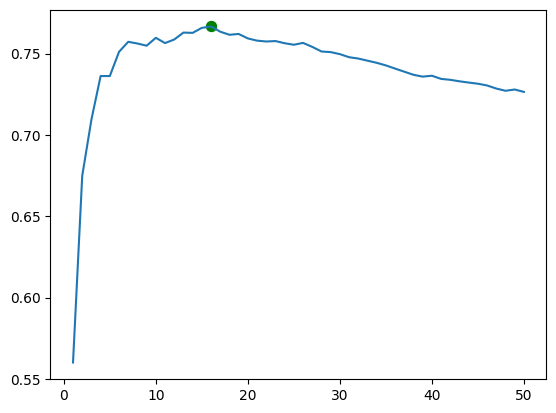

In [23]:
sns.lineplot(y=K_and_score.keys(), x=K_and_score.values())
sns.scatterplot(y=[max_score], x=[max_k], color="green", s=80)

❓Can you guess what makes GridSearchCV a better option than such manual loop ?


<details>
    <summary>Answer</summary>

- Sklearn's `n_jobs=-1` allows you to parallelize the search, utilizing all of your CPU cores
- What if you had multiple hyper-parameters to co-optimize?
</details>

## 5. GridSearch with multiple parameters

👩🏻‍🏫 KNNRegressor suppports various _distance metrics_ via the hyper-parameter `p` 

📚 [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

❓ **Question (tuning multiple parameters)** ❓


* Use GridSearchCV to search for the best $K$ and $p$ simultaneously.
    * Try all combinations for $K = [1, 5, 10, 20, 50]$ and $p = [1, 2, 3]$. 

In [24]:
knn_reg_Kp = KNeighborsRegressor()

# Hyperparameter Grid
grid = {"n_neighbors": [1, 5, 10, 20, 50], "p": [1, 2, 3]}

# Instantiate Grid Search
search = GridSearchCV(
    knn_reg_Kp,
    grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=1,  # parallelize computation
)

# Fit data to Grid Search
search.fit(X_train_scaled, y_train)
search

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50], 'p': [1, 2, 3]},
             scoring='r2', verbose=1)

In [25]:
search.best_estimator_

KNeighborsRegressor(n_neighbors=10, p=1)

In [26]:
search.best_score_

0.7969255879201194

In [27]:
search.refit_time_

0.0065555572509765625

❓ **Question (number of submodels)**❓

How many submodels did you train overall?

<details>
    <summary>Hint</summary>

Much more than 15. Think twice :)
    <details>
    <summary>Answer</summary>

75 models due to CV=5
</details>

In [28]:
# 75 submodels.

❓ **Question (best parameters and best score after tuning the model with multiple parameters)**❓

What are the *best parameters* and the *best score*?

In [29]:
print(search.best_score_)
print(search.best_params_)


0.7969255879201194
{'n_neighbors': 10, 'p': 1}


## 6. Random Search

Now let's see whether a RandomizedSearch can find a better combination with the same number of models being fitted.

❓ **Question (RandomizedSearchCV)** ❓

Use `RandomizedSearchCV` to
- Randomly sample $K$ from a uniform `scipy.stats.randint(1,50)` ([doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html)) distribution
- Sample $p$ from a list $[1,2,3]$
- Use the correct numbers of `n_iter` and `cv` to fit the exact same numbers of models as in your previous GridSearchCV.

In [30]:
knn_reg = KNeighborsRegressor()

# Hyperparameter Grid
grid = {"n_neighbors": sp.stats.randint(1, 20), "p": [np.random.choice([1, 2, 3])]}

# Instantiate Grid Search
search = RandomizedSearchCV(
    knn_reg,
    grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    n_iter=15,
    verbose=1,
)

# Fit data to Grid Search
search.fit(X_train_scaled, y_train)
search

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_iter=15, n_jobs=-1,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd762d47190>,
                                        'p': [2]},
                   scoring='r2', verbose=1)

In [31]:
search.best_estimator_

KNeighborsRegressor(n_neighbors=16)

In [32]:
search.best_score_

0.7666311417513013

In [33]:
search.refit_time_

0.007279634475708008

## 7. Generalization

❓ **Question (finetuning your model one more time)**❓

- Refine your RandomsearchCV if you want
- Choose your best model

In [34]:
knn_regressor_best = KNeighborsRegressor(n_neighbors=10, p=1)

Now try to display your `cv_results` as a `DataFrame`, this will help you visualize what's going on inside the CV! 😉

In [35]:
cv_results =  cross_validate(estimator=knn_regressor_best, X=X_train_scaled, y=y_train)
pd.DataFrame(cv_result)

,fit_time,score_time,test_score
0,0.010120,0.130754,0.542701
1,0.009357,0.027288,0.684186
2,0.008355,0.040992,0.250163
3,0.009721,0.027659,0.778582
4,0.009336,0.064183,0.545139


❓ **Question (Evaluation of the "best" model)** ❓

* Time has come to discover our model's performance with "best params" on the **unseen** test set `X_test`.
    * Compute the r2 score for the test set and save it as `r2_test`.

In [36]:
knn_regressor_best.fit(X_train_scaled, y_train)
r2_test = knn_regressor_best.score(X_test_scaled, y_test)
r2_test

0.7731141456725311

❓ **Question (Taking a step back)** ❓

Would you consider the optimized model to generalize well?

<details><summary>Answer</summary>

Test score may decrease a bit with train set. Probably not more than 5%. This can be due to
- A non-representative train/test split
- A cross-val number too small leading to overfitting the model-tuning phase. The more you cross-validated, the more robust your findings will generalize - but you can't increase cv too much if your dataset is too small as you won't keep enough observations in each fold to be representative.
- Our dataset is very small and our hyperparameter optimization is thus extremely dependent (and overfitting) on our train/test split. Always make sure your dataset is much bigger than the total number of hyperparameter combinations you are trying out!
    
</details>

***🧪 Test your code***

In [37]:
from nbresult import ChallengeResult
result = ChallengeResult('r2',
                         r2_test=r2_test)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/branchedelac/code/branchedelac/05-ML/05-Model-Tuning/data-workflow/tests
plugins: anyio-3.6.2, asyncio-0.19.0, typeguard-2.13.3
asyncio: mode=strict
collecting ... collected 1 item

test_r2.py::TestR2::test_r2 PASSED                                       [100%]

============================== 1 passed in 0.50s ===============================


💯 You can commit your code:

git add tests/r2.pickle

git commit -m 'Completed r2 step'

git push origin master



🏁 Congratulations! Now, you know how to finetune a model using either a GridSearchCV or a RandomizedSearchCV 

💾 Don't forget to `git add/commit/push` your notebook...

🚀 ... and move on to the next challenge!